# Flatiron School Data Science Immersive 
# Module 1 Project 
## Multivariate Analysis: Home Prices in King County, WA

##### Author: Valentina C. Fontiveros

<img src="house_banner.png"/>

## Objectives

> To use data science tools to complete a multivariate analysis of factors influencing home prices in King County, WA.

> To demonstrate the skills gained after completing Module 1 of the Data Science Immersive.

## Background

> The dataset* used in this analysis records physical characteristics and prices of approximately twenty thousand housing units sold in King County, WA during 2014 and 2015.

> Seattle, a major tech hub in the world, is located in this county.

> As of 2010, it was the most densely-populated county in Washington.

> *Flatiron School has provided and modified the original dataset.


##### Population Density of Washington State counties.

<img src= "King_County.jpg"/>

## Data Analysis | OSEMiN Framework 

> On this project, we will use the OSEM Data Science framework.

> OSEM stands for:
    > Obtain 
    > Scrub 
    > Explore 
    > Model 
    > Interpret

### Import Libraries

> The libraries used provide useful tools for data science workflows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 
from scipy.stats import kurtosis, skew
import folium
from folium import plugins
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

### Obtain and Sort Data

> Set index to ID
> Ordered by price,zipcode,then ID

In [2]:
df = pd.read_csv('kc_house_data.csv') # dataset provided by Flatiron School
df.set_index('id', inplace=True)
df.sort_values(by =['price','zipcode','id'], inplace=True, ascending=True)
df.head() #preview data



,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
40000362,5/6/2014,78000.0,2,1.00,780,16344,1.0,0.0,0.0,1,5,780,0.0,1942,NaN,98168,47.4739,-122.280,1700,10387
8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,NaN,0.0,2,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500
3028200080,3/24/2015,81000.0,2,1.00,730,9975,1.0,NaN,0.0,1,5,730,0.0,1943,0.0,98168,47.4808,-122.315,860,9000
3883800011,11/5/2014,82000.0,3,1.00,860,10426,1.0,0.0,0.0,3,6,860,0.0,1954,0.0,98146,47.4987,-122.341,1140,11250
1623049041,5/8/2014,82500.0,2,1.00,520,22334,1.0,0.0,0.0,2,5,520,0.0,1951,0.0,98168,47.4799,-122.296,1572,10570


> There are a number of columns which were not 
visible on the preview display. Let's display all the column names.

In [3]:
print('There are ' + str(len(df.columns)) + ' columns in the dataframe.')
df.columns


There are 20 columns in the dataframe.


Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

> We see 20 columns of information, describing various attributes of houses in King County.

## Scrub Data 

### House Prices:  
 

#### Price - Distribution

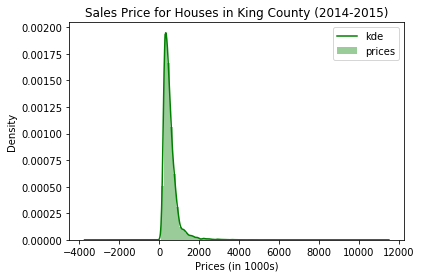

Skewness = 4.023085207745835
kurtosis = 34.53308449607733


In [4]:
# generate histogram for price containing all data
prices = df.price/1000
prices.hist(label = 'prices', bins=50,density=True,color='green',alpha=0.4)
prices.plot.kde(label='kde',color = 'green')
plt.title('Sales Price for Houses in King County (2014-2015)')
plt.xlabel('Prices (in 1000s)')
plt.legend()
plt.show()
print ('Skewness =', skew(df.price))
print ('kurtosis =', kurtosis(df.price))


Observations: high positive skew, extremely high + curtosis, long-tailed distribution.

#### Price - Summary Statistics

In [5]:
# Summary statitics
df.price.describe().apply(lambda x: format(x, 'f'))

count      21597.000000
mean      540296.573506
std       367368.140101
min        78000.000000
25%       322000.000000
50%       450000.000000
75%       645000.000000
max      7700000.000000
Name: price, dtype: object

Observations: ~ 20,000 samples, high standard deviation / variability

Text(0.5, 1.0, 'Distribution of House Prices (in 1000s)')

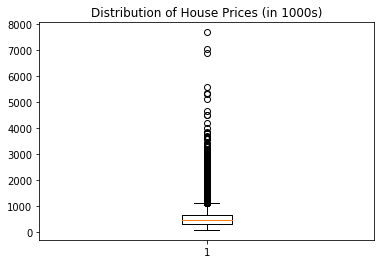

In [6]:
# Spot outliers
plt.boxplot(df.price/1000)
plt.title('Distribution of House Prices (in 1000s)')

Observations: numerous outliers

#### Price - Store in Dataframe after log normalizing

Skewness = 0.43097424174908705
kurtosis = 0.6906107356267639


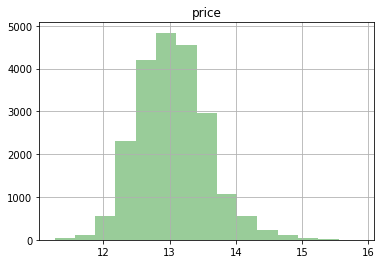

In [7]:
# Take the log of price and store in
price_df = pd.DataFrame(np.log(df.price))
price_df.hist(bins=15,color='green',alpha=0.4)
print ('Skewness =', skew(price_df.price))
print ('kurtosis =', kurtosis(price_df.price))

After log normalizing, the skewness and kurtosis improved.

#### Price - Data Type

In [8]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 1 columns):
price    21597 non-null float64
dtypes: float64(1)
memory usage: 337.5 KB


Observation: price is a float, which is appropriate due to the log transformation.

### Features - Store in Dataframe

In [9]:
# create a dataframe for features
features = df.columns.drop(['price'])
features_df = pd.DataFrame(df[features])
features_df.head(2)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
40000362,5/6/2014,2,1.00,780,16344,1.0,0.0,0.0,1,5,780,0.0,1942,NaN,98168,47.4739,-122.280,1700,10387
8658300340,5/23/2014,1,0.75,430,5050,1.0,NaN,0.0,2,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500


###   Features: Descriptive Statistics

#### Data Types 

In [10]:
# obtain column info
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 19 columns):
date             21597 non-null object
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(7), int64(10), object(2)
memory usage: 3.3+ MB


Observations:

> There are numerous variables that should be tranformed to categories.

> There are geographical features that would be interesting to display on a map.

> Some variables could be transformed from float to int for efficiency.

### Transform Data Types

Scan features to determine best transformation

In [11]:
# This function scans features dataframe for unique values

# Even though this output is large, scanning all the data is important
# if we are not familiar with its peculiarities.

def unique(features_df):
    for column in features_df:
        print('Name: ' + column)
        print('-'*10)
        na = features_df[column].isna().sum()
        print('NaN values: ' + str(na))
        print('-'*10)
        unique = features_df[column].unique()

        print(unique)

        print('')

In [12]:
unique(features_df)

Name: date
----------
NaN values: 0
----------
['5/6/2014' '5/23/2014' '3/24/2015' '11/5/2014' '5/8/2014' '5/29/2014'
 '4/30/2015' '3/5/2015' '9/15/2014' '7/22/2014' '10/14/2014' '2/19/2015'
 '5/13/2014' '11/29/2014' '4/18/2015' '3/3/2015' '6/16/2014' '5/5/2015'
 '9/19/2014' '12/12/2014' '4/8/2015' '10/29/2014' '1/5/2015' '7/17/2014'
 '5/7/2014' '7/3/2014' '6/10/2014' '6/30/2014' '9/4/2014' '7/1/2014'
 '12/8/2014' '9/2/2014' '3/17/2015' '7/16/2014' '11/26/2014' '8/28/2014'
 '1/14/2015' '9/18/2014' '3/11/2015' '5/12/2014' '10/30/2014' '1/27/2015'
 '6/11/2014' '4/27/2015' '5/19/2014' '2/11/2015' '7/25/2014' '10/17/2014'
 '7/10/2014' '12/5/2014' '7/8/2014' '2/24/2015' '7/15/2014' '1/16/2015'
 '9/24/2014' '10/21/2014' '9/16/2014' '6/4/2014' '1/21/2015' '6/19/2014'
 '10/27/2014' '5/20/2014' '8/4/2014' '3/6/2015' '4/20/2015' '4/22/2015'
 '7/2/2014' '12/26/2014' '12/15/2014' '10/3/2014' '3/26/2015' '5/28/2014'
 '9/5/2014' '10/2/2014' '12/10/2014' '8/26/2014' '10/9/2014' '4/28/2015'
 '11/13/20

NaN values: 3842
----------
[  nan    0. 2007. 2003. 1989. 2009. 1950. 1974. 1960. 1957. 1963. 1993.
 2005. 1995. 1977. 1972. 1997. 2014. 1996. 1990. 1987. 1965. 2001. 2013.
 1964. 1983. 1969. 1984. 1992. 1967. 1953. 1991. 1968. 1985. 1986. 1998.
 1945. 1988. 1981. 1975. 2006. 1951. 2004. 2015. 2008. 1973. 2012. 2000.
 2010. 1940. 1976. 2011. 1980. 1970. 1958. 1999. 1979. 1955. 1959. 2002.
 1982. 1948. 1962. 1994. 1978. 1971. 1934. 1956. 1944. 1946. 1954.]

Name: zipcode
----------
NaN values: 0
----------
[98168 98014 98146 98032 98023 98034 98092 98106 98108 98178 98002 98058
 98198 98001 98055 98166 98042 98148 98118 98038 98126 98188 98019 98030
 98022 98117 98003 98027 98033 98116 98133 98010 98056 98031 98155 98028
 98070 98112 98053 98065 98059 98045 98125 98144 98024 98072 98115 98136
 98122 98109 98052 98103 98011 98177 98006 98008 98077 98074 98029 98107
 98007 98119 98199 98102 98105 98005 98075 98004 98040 98039]

Name: lat
----------
NaN values: 0
----------
[47.4739 47.64

> We can see above than none of the categorical variables are identified as such.
> We need to transform the type for several of these variables.

There are problems with various variables.
Address those one variable at a time below 

#### 1. 'sqft_basement' feature

This feature contains unknown values marked with a "?"

In [13]:
# Let's explore how many ? entries are in sqft_basement.
value = '?'
count = 0
for row in features_df['sqft_basement']:
    if row == '?':
        count +=1
print('There are ' + str(count) + ' rows with question marks as unknown values.')
print('This represents ' + str(round(count/len(features_df)*100,2)) + ' percent of the data.')

There are 454 rows with question marks as unknown values.
This represents 2.1 percent of the data.


In [14]:
value = 0
count = 0
for row in features_df['sqft_basement']:
    if row == '0.0':
        count +=1
print('There are ' + str(count) + ' rows with 0 as unknown values.')
print('This represents ' + str(round(count/len(features_df)*100,2)) + ' percent of the data.')

There are 12826 rows with 0 as unknown values.
This represents 59.39 percent of the data.


> There are several ways to transform the unknown ? entries. We could drop these rows or replace them with the median (which is zero)

> Personally, I prefer replacing with the median to begin with, which would introduce a neglible amount of noise.

The median value for this basement area is: 0.0
The mean value for this basement area is: 291.851723974838


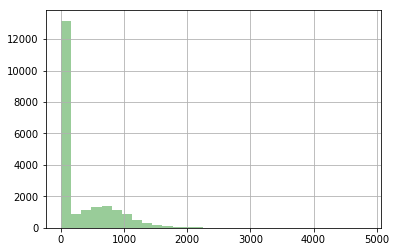

In [15]:
# Because we can't calculate the mean of the dataset with strings, let's create a dummy
# variable to replace the question mark with first.
value = '?'
dummy = 99999
############# . df.loc[:,"Score1"].median()

features_df.loc[:,'sqft_basement'].replace(value, dummy,inplace=True) 

# Now let's convert the type to int
features_df['sqft_basement'] = features_df['sqft_basement'].map(lambda x: float(x))
features_df['sqft_basement'] = features_df['sqft_basement'].map(lambda x: int(x))
features_df['sqft_basement'].unique()[0:15]

# Now let's replace 99999 with the median
features_df.loc[:,'sqft_basement'].replace(dummy,np.nan, inplace=True) 

# Let's plot a histogram 
features_df['sqft_basement'].hist(bins=30,color='green',alpha=0.4)
print('The median value for this basement area is: ' + str(features_df['sqft_basement'].median()))
print('The mean value for this basement area is: ' + str(features_df['sqft_basement'].mean()))


> Since the median for known basement values is zero, we will replace the unknown ? values
> with zero.


In [16]:
# Replace original '?' entries with zeros.
median_sqft = features_df['sqft_basement'].median()
features_df['sqft_basement']= features_df['sqft_basement'].replace(np.nan, median_sqft) 
features_df['sqft_basement'].unique()[0:10]
features_df.sqft_basement = features_df.sqft_basement.astype(int)
print('Done replacing "?" with zeros in sqft_basement')


Done replacing "?" with zeros in sqft_basement


#### 2. 'date' feature:

> Create a column for the year sold based on 'date'. Reformat to integer.
> We will assume that the exact day of the sale is not relevant to our analysis.

In [17]:
# compute two new features: yr_sold and month_sold
features_df['yr_sold'] = features_df['date'].map(lambda x: x.split('/',3))
features_df['month_sold'] = features_df['yr_sold'].map(lambda x: int(x[0]))
features_df['yr_sold'] = features_df['yr_sold'].map(lambda x: int(x[2]))

print('Years of reported sales:')
print(features_df['yr_sold'].unique())
print('Months of reported sales:')
print(features_df['month_sold'].unique())
#features_df.drop('date', axis=1, inplace=True)

Years of reported sales:
[2014 2015]
Months of reported sales:
[ 5  3 11  4  9  7 10  2  6 12  1  8]


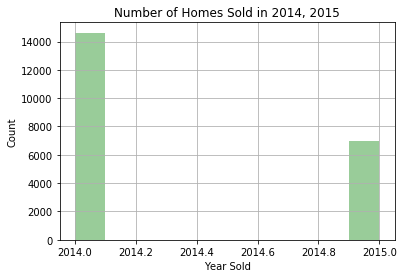

In [18]:
# Explore how many homes were sold in 2014 and 2015
features_df.yr_sold.hist(color='green',alpha=.4)
plt.xlabel('Year Sold')
plt.ylabel('Count')
plt.title('Number of Homes Sold in 2014, 2015')
plt.show()

> Observations: Sales decreased by nearly 50% in 2015.

Mean price in 2014: 538411.0
Mean price in 2015: 538071.0


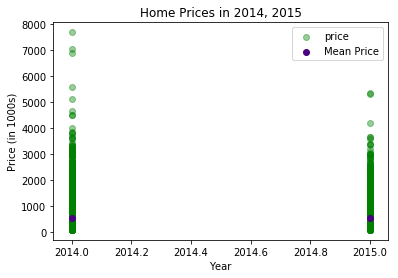

In [19]:
# Find out whether mean/median prices changed from one year to the next.
temp_price = pd.DataFrame(data=df.price)
temp_df = temp_price.join(features_df, how='left')
plt.scatter(temp_df.yr_sold,temp_df.price/1000,color='green',alpha=0.4)
plt.scatter(2014, temp_df.price[temp_df.yr_sold == 2014].mean()/1000, color='indigo',label='Mean Price') 
plt.scatter(2015, temp_df.price[temp_df.yr_sold == 2015].mean()/1000, color='indigo') 
print('Mean price in 2014: ' + str(round(temp_df.price[temp_df.yr_sold==2014].mean(),0)))
print('Mean price in 2015: ' + str(round(temp_df.price[temp_df.yr_sold==2015].mean(),0)))
plt.title('Home Prices in 2014, 2015')
plt.xlabel('Year')
plt.ylabel('Price (in 1000s)')
plt.legend()
plt.show()

> No significant differences are apparent in value of home prices between 2014 and 2015. 
> This probably suggests that this data has been edited for the purposes of this project.
> There is no clear discrimination of price year after year, even though 2014 contains most of the outliers.

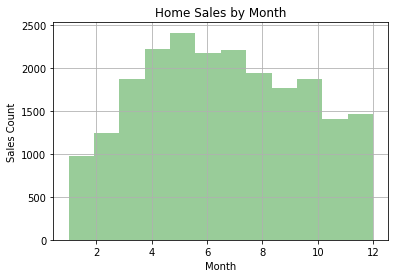

In [20]:
features_df.month_sold.hist(color='green',alpha=.4,bins=12)
plt.title('Home Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales Count')
plt.show()

> Observations: Sales pick up in the Spring, peak in May and slow down in late Fall and Winter.

521258.85814185813
505003.54972592014
540361.4801670146
557871.8432408631
549682.1713586291
557952.8548752834
544555.1982102909
535892.6610772358
527285.4145798553
537344.5131302521
520738.6993006993


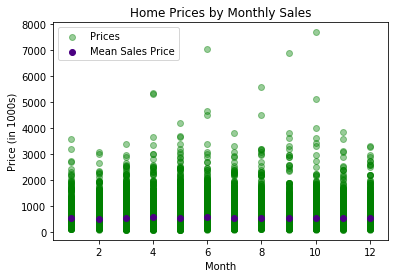

In [21]:
plt.scatter(temp_df.month_sold,temp_df.price/1000,color='green',alpha=0.4,label='Prices')
for x in range(1,12):
    plt.scatter(x, temp_df.price[temp_df.month_sold == x].mean()/1000, color='indigo')
    print(temp_df.price[temp_df.month_sold == x].mean())
plt.scatter(12, temp_df.price[temp_df.month_sold == 12].mean()/1000, color='indigo',label='Mean Sales Price')    
plt.xlabel('Month')
plt.ylabel('Price (in 1000s)')
plt.title('Home Prices by Monthly Sales')
plt.legend()
plt.show()

> Observations: Mean/Median home values do not change month to month

> Conclusion: There is no value in adding these features to the model
> since they do not explain price variations.

In [22]:
# drop irrelevant information

features_df.drop('yr_sold',axis=1,inplace=True)
features_df.drop('month_sold',axis=1,inplace=True)
features_df.drop('date',axis=1,inplace=True)

### Explore Correlated Variables

Finding correlations between variables is important at this stage to keep
in mind for the later analysis.

In [23]:
# this function returns a dataframe pinpointed correlated variables
# that exceed a correlation threshhold. 
def find_corr_vars(df, threshhold):
    
    threshhold = threshhold
    corr_vars0 = df.corr()
    print('Numbers of variables tested')
    print(len(corr_vars0.columns))
    corr_vars = (corr_vars0 > threshhold)
    length = len(corr_vars0.columns)
    print('Correlations tested:')
    print(corr_vars.size)
    print('Correlations meeting threshhold:')
    print(corr_vars.sum().sum() - length)

    rows=[]
    columns=[]
    for column in range(0,length):
        for row in range(0,length):
            if corr_vars.iloc[row][column] == True:
                rows.append(row)
                columns.append(column)
    corr1 = []
    corr2 = []
    words = list(corr_vars.columns)
    for index in rows:
        word = words[index]
        corr1.append(word)
    for index2 in columns:
        corr2.append(words[index2])

    corr_df = pd.DataFrame(data={'col1': corr1,'col2':corr2})
    print('')

    print('Correlated Variables over threshhold ' + str(threshhold))

    return corr_df[corr_df.col1 != corr_df.col2]

In [24]:
threshhold = 0.75 #set correlation threshhold minimum to filter correlations.
# let's find correlated variables above a certain threshhold
feat_price_df = features_df.join(price_df, how='left')
find_corr_vars(feat_price_df, threshhold).sort_values(by='col1',ascending=False)

Numbers of variables tested
19
Correlations tested:
361
Correlations meeting threshhold:
10

Correlated Variables over threshhold 0.75


,col1,col2
7,sqft_living15,sqft_living
2,sqft_living,bathrooms
13,sqft_living,grade
16,sqft_living,sqft_above
25,sqft_living,sqft_living15
6,sqft_above,sqft_living
15,sqft_above,grade
5,grade,sqft_living
17,grade,sqft_above
3,bathrooms,sqft_living


> Observation: We see here that sqft_living and correlated variables
> have a marked correlation with price even before processing the data

#### Set Categorical Variables / Reformat

#### 1. 'sqft_basement' feature

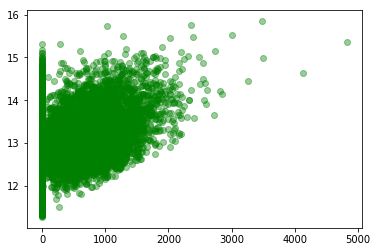

In [25]:
# tried to deal with this feature in various ways
# after dropping zeros, the feature correlated highly with sqft_living
# finally decided to make it a binary variable denoting presence of basement.
plt.scatter(features_df.sqft_basement,price_df.price,color='green',alpha=.4)

In [26]:
features_df['basement'] = round(features_df['sqft_basement'],0).astype(int)

d = {range(0,0):0, range(1,features_df.sqft_basement.max()):1}

features_df['basement'] = features_df['sqft_basement'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
features_df['basement'] = features_df['basement'].astype('category')

In [27]:
features_df['basement'].unique()

[0, 1]
Categories (2, int64): [0, 1]

#### 2. 'yr_sold' feature

In [28]:
# dropped from analysis due to nil contribution to price variations

#### 3. 'bathrooms' feature

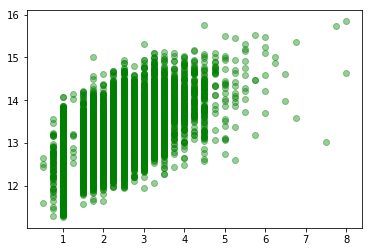

In [29]:
plt.scatter(features_df.bathrooms,price_df.price,color='green',alpha=.4)

In [30]:
# Initially, this variable was transformed to a category.
# For now, we will leave 'as is'

#### 4. 'waterfront' feature:

Waterfront Mean Price: 1717215.0
No Waterfront Mean Price: 530876.0


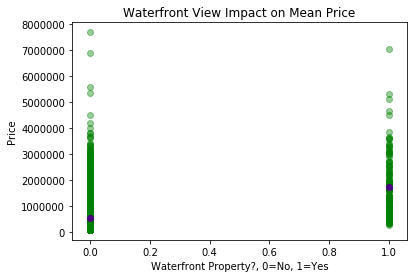

In [31]:
plt.scatter(temp_df.waterfront,temp_df.price,color='green',alpha=.4)
plt.scatter(0, (temp_df.price[temp_df.waterfront==0]).mean(),color='indigo')
plt.scatter(1, (temp_df.price[temp_df.waterfront==1]).mean(),color='indigo')
plt.xlabel('Waterfront Property?, 0=No, 1=Yes')
plt.ylabel('Price')
plt.title('Waterfront View Impact on Mean Price')
print('Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==1]).mean(),0)))
print('No Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==0]).mean(),0)))

> Waterfront properties are valued over a million dollars higher!

In [32]:
# fill NaN values in waterfront and view with zeros.
features_df.waterfront.fillna(0,inplace=True) # 10% of data was missing.
features_df['waterfront'] = features_df['waterfront'].astype(int).astype('category')

Waterfront Mean Price: 1717215.0
No Waterfront Mean Price: 530408.0


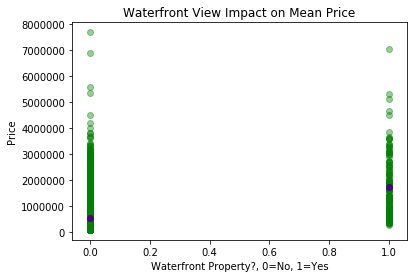

In [33]:
# check that changes did not impact distribution
temp_df.waterfront.fillna(0,inplace=True)
plt.scatter(temp_df.waterfront,temp_df.price,color='green',alpha=.4)
plt.scatter(0, (temp_df.price[temp_df.waterfront==0]).mean(),color='indigo')
plt.scatter(1, (temp_df.price[temp_df.waterfront==1]).mean(),color='indigo')
plt.xlabel('Waterfront Property?, 0=No, 1=Yes')
plt.ylabel('Price')
plt.title('Waterfront View Impact on Mean Price')
print('Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==1]).mean(),0)))
print('No Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==0]).mean(),0)))

> Filling NaN values did not affect the main conclusion about the waterfront feature.

#### 5. 'view' feature:

0 494978.46473029046
1 811869.5120481928
2 790402.0698644421
3 974161.2451361867
4 1449277.6625386998


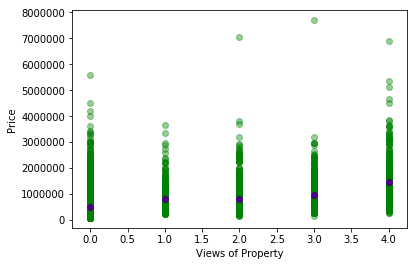

In [34]:
plt.scatter(temp_df.view,temp_df.price, color='green', alpha=0.4)
for view in range(0,5):
    plt.scatter(view, (temp_df.price[temp_df.view == view]).mean(),color='indigo')
    print(str(view) + ' ' + str((temp_df.price[temp_df.view == view]).mean()))
plt.xlabel('Views of Property')
plt.ylabel('Price')
plt.show()


In [35]:

features_df.view.fillna(0,inplace=True)       # less than 1% of data was missing.
features_df['view'] = features_df['view'].astype(int).astype('category')


#### 6. 'bedrooms' feature:

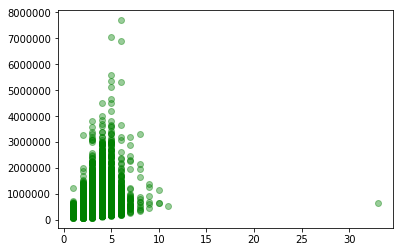

In [36]:
plt.scatter(features_df.bedrooms,df.price, color='green', alpha=0.4)

In [37]:
# initially set as category, changed it back to int

#replace type first to INT then to CATEGORY. No variables needed FLOAT type.
features_df['bedrooms'] = features_df['bedrooms'].astype(int)


#### 7. 'floors' feature:

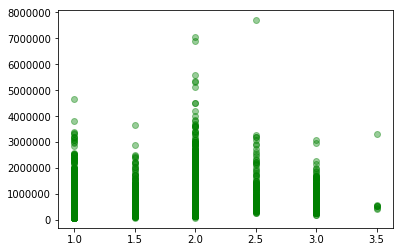

In [38]:
plt.scatter(features_df.floors,df.price, color='green', alpha=0.4)

In [39]:
# bin features and set as category
features_df['floors'] = round(features_df['floors'],0).astype(int)

d = {range(0,2):'1', range(2,4):'2plus'}

features_df['floors'] = features_df['floors'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
features_df['floors'] = features_df['floors'].astype('category')

#### 8. 'conditions' feature

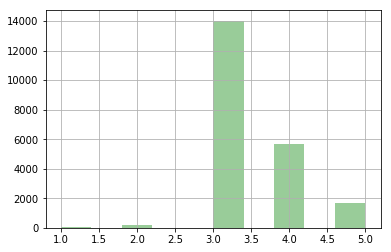

In [40]:
features_df['condition'].hist(color='green',alpha=.4)

In [41]:
# bin features and set as category

features_df['condition'] = features_df['condition'].astype(int)
d = {range(0,3):'poor', range(3,4):'average',range(4,6):'above_average'}
features_df['condition'] = features_df['condition'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))

features_df['condition'] = features_df['condition'].astype('category')

#### 9. 'zipcode' feature

In [42]:
features_df['zipcode'] = features_df['zipcode'].astype(int).astype('category')

# change a format for basement variable so that all sqft are int

#### 10. 'grade' feature:

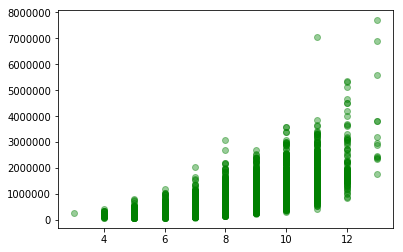

In [43]:
plt.scatter(features_df.grade,df.price, color='green', alpha=0.4)

In [44]:
# changed from category back to int
features_df['grade'] = features_df['grade'].astype(int)

#### 11. 'yr_renovated' feature:

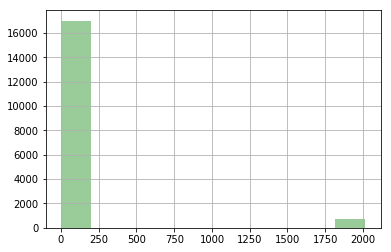

In [45]:
features_df.yr_renovated.hist(color='green',alpha=.4)

In [46]:
renov_temp = temp_df[temp_df.yr_renovated != 0]
no_renov_temp = temp_df[temp_df.yr_renovated == 0]

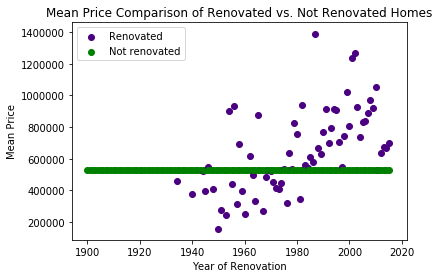

In [47]:
#plt.scatter(renov_temp.yr_renovated,renov_temp.price, color='green', alpha=0.4)

#plt.scatter(2010,(renov_temp.price[renov_temp.yr_renovated]==2010).median(),color='indigo')

#plt.hist((no_renov_temp.price[no_renov_temp.yr_renovated]).median(),color='green')
for year in range(1900,2015):
    plt.scatter(year, (renov_temp.price[renov_temp.yr_renovated==year]).mean(),color='indigo')
    plt.scatter(year, (no_renov_temp.price.mean()),color='green')
plt.scatter(2015, (renov_temp.price[renov_temp.yr_renovated==2015]).mean(),color='indigo',label='Renovated')
plt.scatter(2015,(no_renov_temp.price.mean()),color='green',label='Not renovated')
plt.xlabel('Year of Renovation')
plt.ylabel('Mean Price')
plt.title('Mean Price Comparison of Renovated vs. Not Renovated Homes')
plt.legend()
plt.show()

In [48]:
# Create categories for renovations based on how recently they occurred.
# Assumption: More recent renovations drive the price up more.
# There are records of renovations that are more than 30 years old.
# For practicality, we will ignore this "old" renovations and only
# consider a house renovated if it was remodeled within the last 30 years.
features_df.yr_renovated.fillna(0,inplace=True)
features_df['yr_renovated'] = features_df['yr_renovated'].astype(int)
d = {range(0,2000):0, range(1990, 2015):1}

features_df['renovated'] = features_df['yr_renovated'].apply(lambda x: next((v for k, v in d.items() if x in k), 'no'))
features_df['renovated'] = features_df['renovated'].astype('category')

#drop yr_renovated from features_df
features_df.drop('yr_renovated',axis=1,inplace=True)
print('Most houses have not been remodeled recently.')

Most houses have not been remodeled recently.


#### 12. 'yr_built' feature

In [49]:
features_df.yr_built.max()

2015

In [50]:
# Create a new feature called 'vintage' that will describe how recently
# a house was built.
d = {range(1900,1970):'Before70s',range(1970, 1980): '70s', range(1980, 1990): '80s', range(1990, 2000): '90s', range(2000, 2010): '2000s',range(2010, 2016): '2010s'}

features_df['built'] = features_df['yr_built'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
print('done')
features_df['built'] = features_df['built'].astype('category')

#drop the year built column, since we categorized it in bins
features_df.drop('yr_built',axis=1,inplace=True)
features_df['built'].head()


done


id
40000362      Before70s
8658300340    Before70s
3028200080    Before70s
3883800011    Before70s
1623049041    Before70s
Name: built, dtype: category
Categories (6, object): [2000s, 2010s, 70s, 80s, 90s, Before70s]

#### 13. 'sqft_lot' feature:

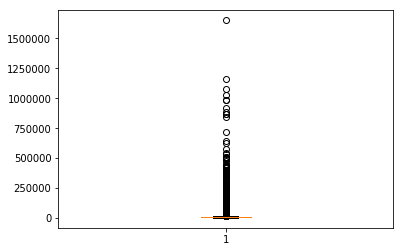

Skewness = 13.071695603822912
kurtosis = 285.4294421924969


In [51]:
plt.boxplot(features_df.sqft_lot)
plt.show()
print ('Skewness =', skew(features_df.sqft_lot))
print ('kurtosis =', kurtosis(features_df.sqft_lot))

Skewness = 0.9624335347705735
kurtosis = 3.328974148585477


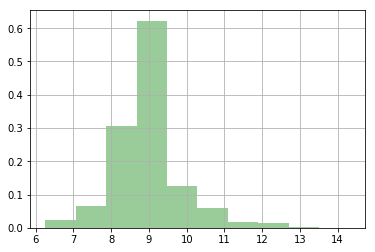

In [52]:
# Create a new feature to deal with lot size
# let's check out the distribution
features_df.sqft_lot = np.log(features_df.sqft_lot)
features_df.sqft_lot.hist(density=True,color='green',alpha=0.4)

print ('Skewness =', skew(features_df.sqft_lot))
print ('kurtosis =', kurtosis(features_df.sqft_lot))




Observations: improved the kurtosis, but it's still a bit high.

#### 14. and 15. 'lat' and 'long' features

> Using the lat lon variables, approximate the distance of houses to downtown seattle.

In [53]:
# calculate a proxy distance from seattle downtown
sea_lat  =  47.6050    # seattle's latitude in decimal degrees
sea_long = -122.3344   # seattle's longitude ''  ''      ''
lat_conv = 69.09       # approximate factor to convert decimal degrees to distance in miles
long_conv = 46.54      # gotten from http://www.csgnetwork.com/degreelenllavcalc.html

# go through latitude and longitude data and calculate component distance 
# from seattle.
features_df['sea_dist_lat'] = abs(sea_lat - features_df['lat'])*lat_conv
features_df['sea_dist_long'] = abs(sea_long - features_df['long'])*long_conv

# Using the components, calculate approximate distance using Pythagorean theorem.
features_df['approx_dist'] = np.sqrt((features_df['sea_dist_lat'])**2 + (features_df['sea_dist_long'])**2)



#### QC distance approximation

> Calculating distances using this method is a crude approximation.

> It is necessary to check whether the results make sense geographically.

> Calculations were validated by mapping the data and researching distances manually.

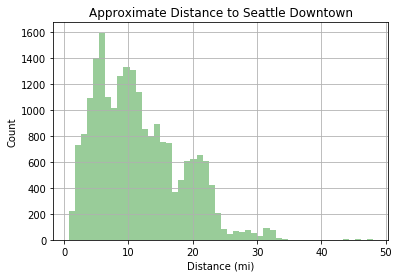

In [54]:
# First QC tool: generate a histogram of distances from the city center
# to the various houses. 
features_df.approx_dist.hist(bins=50,color='green',alpha=.4)
plt.xlabel('Distance (mi)')
plt.ylabel('Count')
plt.title('Approximate Distance to Seattle Downtown')
plt.show()

In [55]:
# Based on this histogram, when we plot a heatmap of locations, most
# houses should be located within a 10-15 radius of the city center.

#### Plot heatmap of location values

In [56]:
# Use the folium utility to create a house density map.
# we used the original lat and long values to determine whether most
# houses are located very near Seattle.

def map_values(center_lat, center_long, df):
   
    m = folium.Map([center_lat,center_long], zoom_start=10)
    folium.Marker([center_lat,center_long]).add_to(m)

    locations = df[['lat', 'long']]
    locationlist = locations.values.tolist()
    m.add_children(plugins.HeatMap(locationlist, radius=20, min_opacity=0.25))
    return m

In [57]:
map_values(sea_lat,sea_long,df)

In [58]:
# Yes, after validating our data using this and outside map
# we can include this distance approximation in our analysis.

In [59]:
# reformat / drop columns 
features_df.drop('sea_dist_long',axis=1,inplace=True)
features_df.drop('sea_dist_lat',axis=1,inplace=True)
features_df.drop('lat',axis=1,inplace=True)
features_df.drop('long',axis=1,inplace=True)
features_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,basement,renovated,built,approx_dist
id,,,,,,,,,,,,,,,,,,
40000362,2,1.00,780,9.701616,1,0,0,poor,5,780,0,98168,1700,10387,0,0,Before70s,9.404882
8658300340,1,0.75,430,8.527144,1,0,0,poor,4,430,0,98014,1200,7500,0,0,Before70s,20.039678
3028200080,2,1.00,730,9.207837,1,0,0,poor,5,730,0,98168,860,9000,0,0,Before70s,8.628347
3883800011,3,1.00,860,9.252058,1,0,0,average,6,860,0,98146,1140,11250,0,0,Before70s,7.350688
1623049041,2,1.00,520,10.013865,1,0,0,poor,5,520,0,98168,1572,10570,0,0,Before70s,8.825987


#### Check data info again


In [60]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 18 columns):
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null float64
floors           21597 non-null category
waterfront       21597 non-null category
view             21597 non-null category
condition        21597 non-null category
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
zipcode          21597 non-null category
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
basement         21597 non-null category
renovated        21597 non-null category
built            21597 non-null category
approx_dist      21597 non-null float64
dtypes: category(8), float64(3), int64(7)
memory usage: 2.6 MB


In [61]:
features_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,approx_dist
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,3.373200,2.115826,2080.321850,8.989805,7.657915,1788.596842,285.716581,1986.620318,12758.283512,11.492200
std,0.926299,0.768984,918.106125,0.902078,1.173200,827.759761,439.819830,685.230472,27274.441950,6.594342
min,1.000000,0.500000,370.000000,6.253829,3.000000,370.000000,0.000000,399.000000,651.000000,0.716749
25%,3.000000,1.750000,1430.000000,8.525161,7.000000,1190.000000,0.000000,1490.000000,5100.000000,6.108846
50%,3.000000,2.250000,1910.000000,8.938269,7.000000,1560.000000,0.000000,1840.000000,7620.000000,10.326178
75%,4.000000,2.500000,2550.000000,9.276596,8.000000,2210.000000,550.000000,2360.000000,10083.000000,15.734412
max,33.000000,8.000000,13540.000000,14.317109,13.000000,9410.000000,4820.000000,6210.000000,871200.000000,48.026074


#### Create heatmaps and correlation matrix

In [62]:
features_df.corr()>.8

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,approx_dist
bedrooms,True,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,True,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,False
sqft_above,False,False,True,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,False,False,True,False,False,False
sqft_living15,False,False,False,False,False,False,False,True,False,False
sqft_lot15,False,False,False,False,False,False,False,False,True,False
approx_dist,False,False,False,False,False,False,False,False,False,True


####  16 , 17, 18 : 'sqft_living' , 'sqft_above' , 'sqft_living15' features

>  These variables are correlated over 70% of the time.
>  Let's choose only one for our model. The best correlated with price!

In [63]:
# calculate correlations with target values for correlated variables
# to choose the best for our model
corr_columns = ['sqft_living','sqft_living15','sqft_above']
df_corr = price_df.join(features_df[corr_columns],how='left')
df_corr.corr()

,price,sqft_living,sqft_living15,sqft_above
price,1.000000,0.695067,0.620297,0.601720
sqft_living,0.695067,1.000000,0.756843,0.876282
sqft_living15,0.620297,0.756843,1.000000,0.731540
sqft_above,0.601720,0.876282,0.731540,1.000000


In [64]:
# based on these results, we will nix:  sqft_abovve

In [65]:
features_df.drop('sqft_above',axis=1,inplace=True)
#we had dropped more features with a threshhold of .75

In [66]:
# transform to float
features_df['sqft_living'] = features_df['sqft_living'].astype(float)

#### 19 sqft_lot15 and sqft_lot

In [67]:
#dropped these before
#features_df.drop('sqft_lot15',axis=1,inplace=True)

In [68]:
# Remaining correlations
features_df.corr()>.8

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_basement,sqft_living15,sqft_lot15,approx_dist
bedrooms,True,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,False,True,False,False,False
sqft_living15,False,False,False,False,False,False,True,False,False
sqft_lot15,False,False,False,False,False,False,False,True,False
approx_dist,False,False,False,False,False,False,False,False,True


In [69]:
# Looks good, no remaining strong correlations!
# for now we will keep these

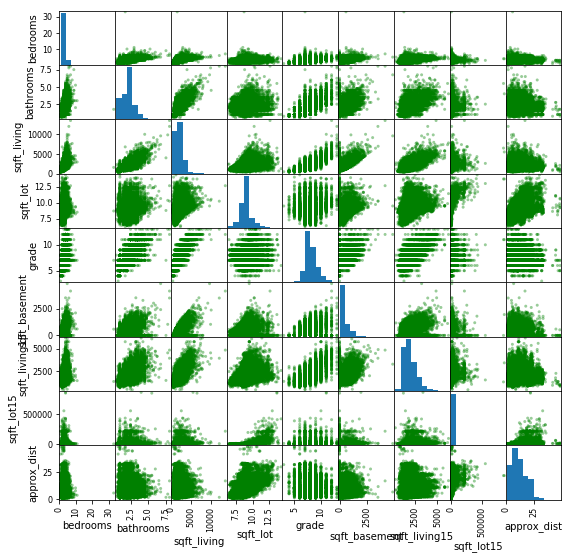

In [70]:
pd.plotting.scatter_matrix(features_df,figsize  = [9, 9], color='green',alpha=0.4)
plt.show()

#### Dummy variables


In [71]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 17 columns):
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null float64
sqft_lot         21597 non-null float64
floors           21597 non-null category
waterfront       21597 non-null category
view             21597 non-null category
condition        21597 non-null category
grade            21597 non-null int64
sqft_basement    21597 non-null int64
zipcode          21597 non-null category
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
basement         21597 non-null category
renovated        21597 non-null category
built            21597 non-null category
approx_dist      21597 non-null float64
dtypes: category(8), float64(4), int64(5)
memory usage: 2.4 MB


In [72]:
features_df['bedrooms'] = features_df['bedrooms'].astype('float')
features_df['grade'] = features_df['grade'].astype('float')
features_df['sqft_basement'] = features_df['sqft_basement'].astype('category')
features_df['sqft_living15'] = features_df['sqft_living15'].astype('float')
features_df['sqft_lot15'] = features_df['sqft_lot15'].astype('float')

In [73]:
#features_df = features_df.drop(cat_vars, axis=1)

#bed= pd.get_dummies(features_df['bedrooms'], prefix="bed")
#bath= pd.get_dummies(features_df['bathrooms'], prefix="bath")
floor= pd.get_dummies(features_df['floors'], prefix="flo")
water= pd.get_dummies(features_df['waterfront'], prefix="water")
view= pd.get_dummies(features_df['view'], prefix="view")
cond = pd.get_dummies(features_df['condition'], prefix="cond")
#grade= pd.get_dummies(features_df['grade'], prefix="grade")
zipc= pd.get_dummies(features_df['zipcode'], prefix="zip")
#sold= pd.get_dummies(features_df['yr_sold'], prefix="sold")
renov = pd.get_dummies(features_df['renovated'], prefix="renov")
built = pd.get_dummies(features_df['built'], prefix="built")
base = pd.get_dummies(features_df['basement'], prefix="base")

In [74]:

features_df = pd.concat([features_df,floor,water,view,cond,renov,built,zipc,base],axis=1) #drop bed bath drop grade as test
features_df.shape

# drop categorical variables written before hot encoding
cat_vars = ['floors','basement','view','sqft_basement','waterfront','condition','zipcode','renovated','built']
features_df.drop(cat_vars,axis=1,inplace=True)

In [75]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Columns: 102 entries, bedrooms to base_1
dtypes: float64(8), uint8(94)
memory usage: 4.0 MB


#### Normalize values

In [76]:
# normalize continuous features in dataframe
column = 'bedrooms'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column = 'bathrooms'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column = 'grade'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()


column ='sqft_living'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='sqft_living15'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='approx_dist'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='sqft_lot'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='sqft_lot15'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()


In [77]:
features_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_living15,sqft_lot15,approx_dist,flo_0,flo_1,...,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,base_0,base_1
id,,,,,,,,,,,,,,,,,,,,,
40000362,-1.482459,-1.451039,-2.101474,0.789080,-2.265527,-0.308765,-0.086942,-0.018108,0,1,...,0,0,1,0,0,0,0,0,1,0
8658300340,-2.562024,-1.776143,-3.505344,-0.512884,-3.117897,-1.372403,-0.192792,1.133406,0,1,...,0,0,0,0,0,0,0,0,1,0
3028200080,-1.482459,-1.451039,-2.257653,0.241700,-2.265527,-2.389740,-0.137795,-0.149285,0,1,...,0,0,1,0,0,0,0,0,1,0
3883800011,-0.402894,-1.451039,-1.871299,0.290721,-1.413157,-1.529040,-0.055300,-0.393229,0,1,...,0,0,0,0,0,0,0,0,1,0
1623049041,-1.482459,-1.451039,-3.057329,1.135224,-2.265527,-0.547810,-0.080232,-0.114811,0,1,...,0,0,1,0,0,0,0,0,1,0


#### Check Linearity Assumptions

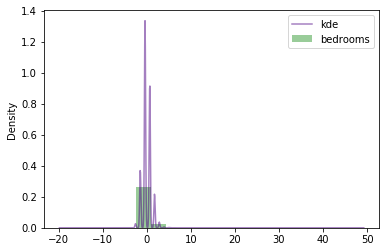

Skewness = 2.023500682470702
kurtosis = 49.81002325740023


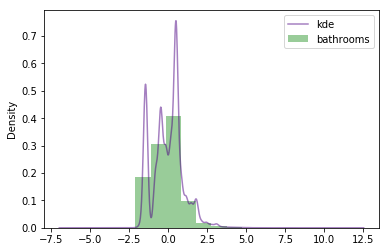

Skewness = 0.5196731850083091
kurtosis = 1.2787413307385336


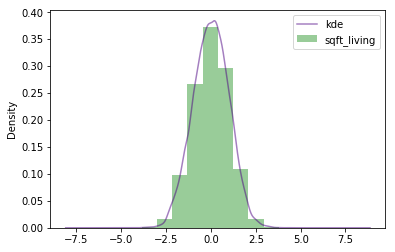

Skewness = -0.027360069339444994
kurtosis = -0.07929775335686351


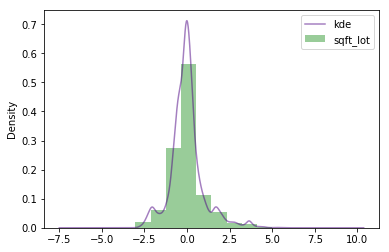

Skewness = 0.9624335347705764
kurtosis = 3.328974148585484


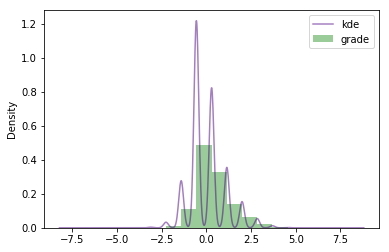

Skewness = 0.7881818890694116
kurtosis = 1.1346074335227243


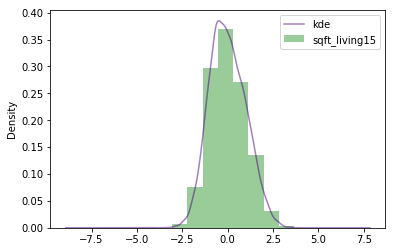

Skewness = 0.205963270751976
kurtosis = -0.20828561479785312


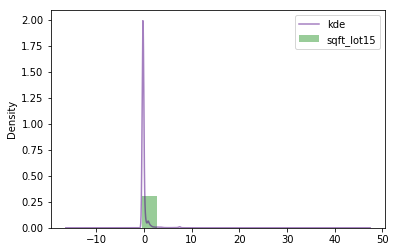

Skewness = 9.523700446454049
kurtosis = 151.36033683166409


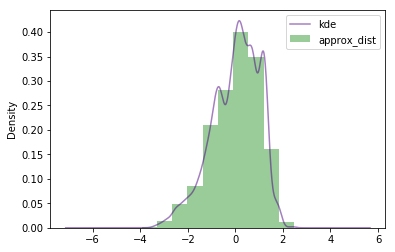

Skewness = -0.598212714437572
kurtosis = 0.004374917825920477


In [78]:
# check distributions for the 3 continuous variables

for column in features_df.iloc[:,0:8]:
    features_df[column].plot.hist(normed=True,color='green',alpha=0.4,label=column, range=(features_df[column].min(),features_df[column].max()))
    features_df[column].plot.kde(label='kde',color='indigo',alpha=0.5)
    plt.legend()
    plt.show()
    print ('Skewness =', skew(features_df[column]))
    print ('kurtosis =', kurtosis(features_df[column]))
    
    
    
    

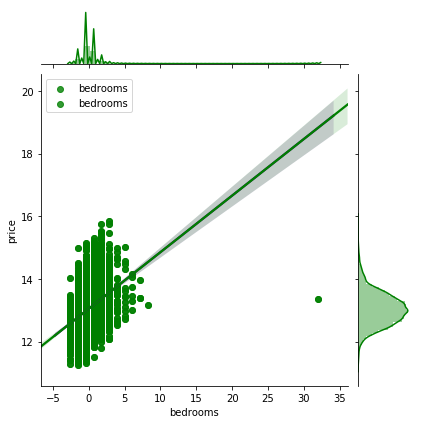

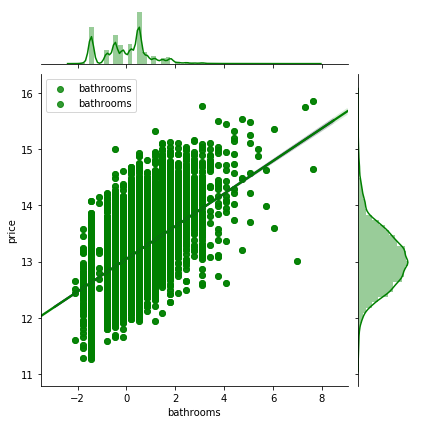

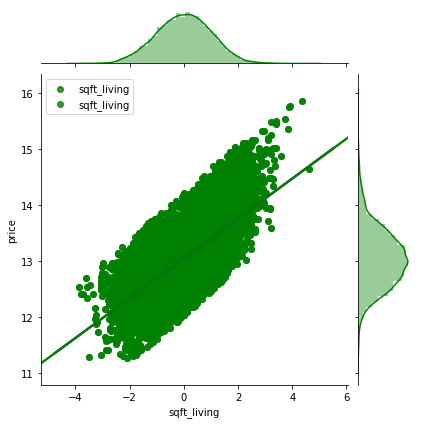

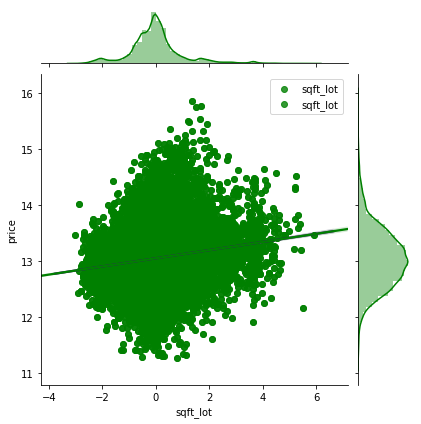

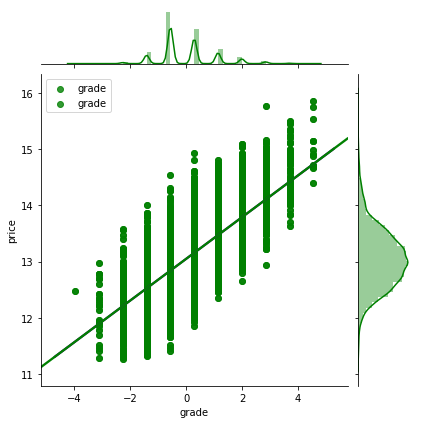

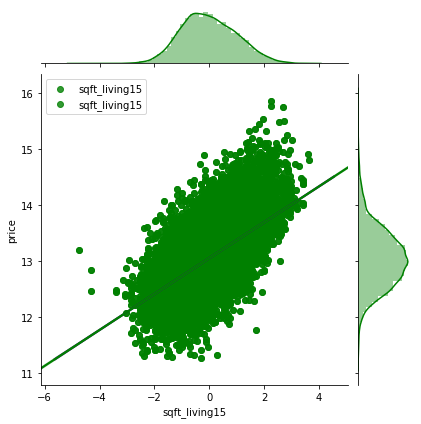

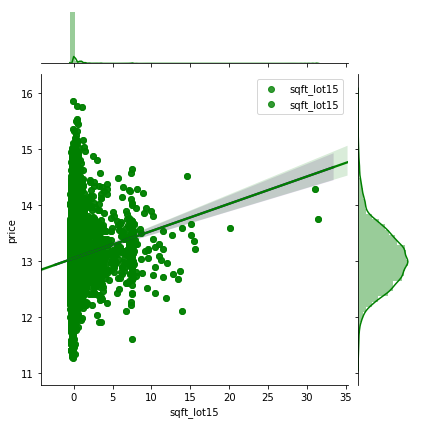

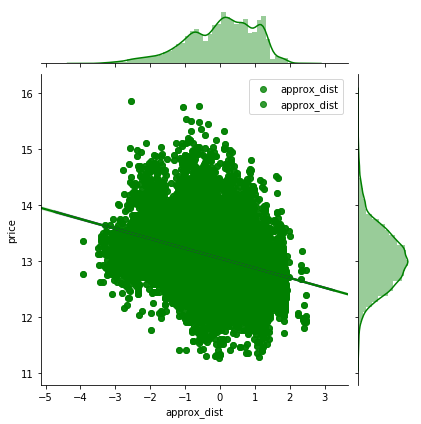

In [79]:
temp_price = price_df['price']
for column in features_df.iloc[:,0:8]:
    sns.jointplot(x=column, y=temp_price,
                  data=features_df, 
                  kind='reg', 
                  color = 'green',
                  label=column,
                  joint_kws={'line_kws':{'color':'indigo'}})
    sns.regplot(features_df[column], temp_price, label=column, color='green')
    plt.legend()
    plt.show()

#### Run first model and identify opportunities for improvement.

### Run Linear Regression for Feature Selection

In [80]:
# returns a dataframe with regression information per variable.
# df is the dataframe containing features
# price_df is the dataframe containing the target
# pvalue is the maximum p-value accepted.

def run_single_linreg(df, price_df,pvalue):
    col_names = df.columns
    data_df = price_df.join(df,how='left')

    results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
    for val in (col_names):
        f = 'price~' + val
        model = smf.ols(formula=f, data=data_df).fit()
        X_new = pd.DataFrame({val: [data_df[val].min(), data_df[val].max()]});
        preds = model.predict(X_new)
        results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    results_df = pd.DataFrame(results, columns=results[0])
    results_df.drop(0,inplace=True)
    results_df.set_index('ind_var',inplace=True)
    results_df = results_df[results_df['p-value']<=pvalue]
    return results_df
    

In [81]:
single_linreg_1 = run_single_linreg(features_df, price_df,0.05)
single_linreg_1.sort_values('r_squared',ascending=False).head()

,r_squared,intercept,slope,p-value
ind_var,,,,
grade,0.496262,13.0465,0.371929,0
sqft_living,0.456005,13.0458,0.357064,0
sqft_living15,0.37019,13.0452,0.321857,0
bathrooms,0.304708,13.0454,0.291872,0
bedrooms,0.116518,13.0437,0.18028,0


### PREDICTORS: 1st Pass

In [82]:
# features selected as 1st pass
predictors1 = list(single_linreg_1.index)
len(predictors1)

features_df = features_df[predictors1]

### Run Multiple Linear Regression Model #1

In [83]:
# This function takes features (predictors) inside a dataframe (df)
# and creates the best fit to explain the 'price' (price_df)

def run_mult_linreg(df, price_df, predictors):
    y = price_df.price
    X = df[predictors]
    n_predictors = len(predictors)
    linreg = LinearRegression()
    r_list = []
    adj_r_list = []
    list_n = list(range(n_predictors//2,n_predictors))  #n predictors calculated above
    for n in list_n: 
        select_n = RFE(linreg, n_features_to_select = n)
        select_n = select_n.fit(X, np.ravel(y))
        selected_columns = X.columns[select_n.support_ ]
        linreg.fit(X[selected_columns],y)
        yhat = linreg.predict(X[selected_columns])
        SS_Residual = np.sum((y-yhat)**2)
        SS_Total = np.sum((y-np.mean(y))**2)
        r_squared = 1 - (float(SS_Residual))/SS_Total
        print(r_squared)
        adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    r_list.append(r_squared)
    adj_r_list.append(adjusted_r_squared)
    print('r-squared: ' + str(r_list))
    print('adj r-squared: ' + str(adj_r_list))
    return linreg

In [84]:
# Run the first linear regression and print r-squared values
mult_linreg1 = run_mult_linreg(features_df,price_df,predictors1)

0.8079288899562624
0.810761060031475
0.812372241472762
0.8159571387172562
0.8458647662023434
0.8472130410890228
0.8476012176807824
0.8483282093584369
0.8496418953904056
0.8500838201509944
0.8508594424444679
0.8513221367634268
0.8516052966665943
0.8519492569605962
0.8522036942967001
0.8522756581762732
0.8523107506697859
0.8645389105332862
0.864914886245308
0.8654279044909794
0.8657780474392403
0.8661340427329394
0.8664617357829125
0.8666266547955193
0.8667868253059003
0.8669440687028054
0.8784190172785125
0.8785030124432742
0.8785520117075705
0.8786911912528463
0.8802126855089581
0.8831858200397241
0.8838528480831377
0.8843498416376179
0.8844902452254096
0.8844911267608285
0.884816973685443
0.885366018368697
0.8853662095049508
0.8853741280334875
0.8853828776365996
0.8853926704360867
0.8854048633700273
0.885458277184423
0.8857110860242502
0.8857270048114418
0.8859286200135863
r-squared: [0.8859286200135863]
adj r-squared: [0.8854352638149751]


#### Cross Validation Scores

In [85]:
def run_cross_validation(linreg,df, price_df, predictors,cv_number):
    y = price_df.price
    X = df[predictors]
    n_predictors = len(list(predictors))
    select_n = RFE(linreg, n_features_to_select = n_predictors)
    select = select_n.fit(X, np.ravel(y))
    selected_columns = X.columns[select_n.support_]

    cv_10_results = cross_val_score(linreg, X[selected_columns], y, cv=10, scoring="neg_mean_squared_error")
    print(str(n_predictors) + ' predictors used.')
    print(cv_10_results)

In [86]:
run_cross_validation(mult_linreg1,features_df,price_df,predictors1,10)

93 predictors used.
[-0.09123486 -0.02897536 -0.0257032  -0.02682593 -0.02592985 -0.02702915
 -0.02476535 -0.02560193 -0.02984534 -0.08802217]


In [87]:
# Large cross-validation values indicate multicollinearity issues!

In [88]:
def run_ols_model(df, price_df,predictors):
    data_df = price_df.join(df,how='left')
    outcome = 'price'

    data_df.info()
    predictors_list = '+'.join(list(predictors))

    formula = outcome + "~" + predictors_list
    model = ols(formula=formula, data=data_df).fit()
    return(model)

In [89]:
ols_model_1 = run_ols_model(features_df,price_df,predictors1)
ols_model_1.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 94 columns):
price              21953 non-null float64
bedrooms           21953 non-null float64
bathrooms          21953 non-null float64
sqft_living        21953 non-null float64
sqft_lot           21953 non-null float64
grade              21953 non-null float64
sqft_living15      21953 non-null float64
sqft_lot15         21953 non-null float64
approx_dist        21953 non-null float64
flo_1              21953 non-null uint8
flo_2plus          21953 non-null uint8
water_0            21953 non-null uint8
water_1            21953 non-null uint8
view_0             21953 non-null uint8
view_1             21953 non-null uint8
view_2             21953 non-null uint8
view_3             21953 non-null uint8
view_4             21953 non-null uint8
cond_average       21953 non-null uint8
cond_poor          21953 non-null uint8
renov_0            21953 non-null uint8
renov_1            219

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1866.
Date:                Tue, 25 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:11:54   Log-Likelihood:                 6441.1
No. Observations:               21953   AIC:                        -1.270e+04
Df Residuals:                   21863   BIC:                        -1.198e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.2745      0.028    187.165      0.000       5.219       5.330
bedrooms           -0.0118      0.002     -7.079      0.000      -0.015      -0.009
bathrooms           0.0252      0.002     11.260      0.000       0.021       0.030
sqft_living         0.1633      0.003     54.350      0.000       0.157       0.169
sqft_lot            0.0822      0.002     34.418      0.000       0.077       0.087
grade               0.1084      0.002     47.870      0.000       0.104       0.113
sqft_living15       0.0482      0.002     22.528      0.000       0.044       0.052
sqft_lot15         -0.0105      0.002     -6.078      0.000      -0.014      -0.007
approx_dist        -0.1808      0.006    -29.778      0.000      -0.193      -0.169
flo_1               0.0565      0.069      0.823      0.411      -0.078       0.191
flo_2plus           0.0613      0.069      0.893      0.372      -0.073       0.196
water_0             2.4252      0.016    151.884      0.000       2.394       2.457
water_1             2.8492      0.018    161.502      0.000       2.815       2.884
view_0              0.9143      0.007    129.159      0.000       0.900       0.928
view_1              1.0258      0.010     97.966      0.000       1.005       1.046
view_2              1.0185      0.008    124.261      0.000       1.002       1.035
view_3              1.0903      0.009    117.938      0.000       1.072       1.108
view_4              1.2255      0.011    106.947      0.000       1.203       1.248
cond_average       -0.0613      0.003    -20.085      0.000      -0.067      -0.055
cond_poor          -0.2053      0.013    -16.321      0.000      -0.230      -0.181
renov_0             1.7299      0.017    101.746      0.000       1.697       1.763
renov_1             1.8600      0.018    102.796      0.000       1.825       1.895
renov_no            1.6845      0.036     47.080      0.000       1.614       1.755
built_2000s         0.0419      0.006      7.456      0.000       0.031       0.053
built_2010s         0.1128      0.007     15.980      0.000       0.099       0.127
built_70s          -0.0196      0.006     -3.523      0.000      -0.031      -0.009
built_90s           0.0102      0.006      1.825      0.068      -0.001       0.021
built_Before70s     0.0204      0.005      4.035      0.000       0.010       0.030
zip_98001          -0.2910      0.012    -24.861      0.000      -0.314      -0.268
zip_98002          -0.2640      0.015    -17.928      0.000      -0.293      -0.235
zip_98003          -0.2677      0.013    -21.164      0.000      -0.293      -0.243
zip_98004           0.5237      0.013     41.692      0.000       0.499       0.548
zip_98005           0.1945      0.015     12.814      0.000       0.165       0.224
zip_98006           0.1579      0.010     16.554      0.000

> Observation: There are multicollinearity issues... Need to remove binary categories or other correlated variables.

> Bedrooms is negatively correlated!

### ANALYSIS

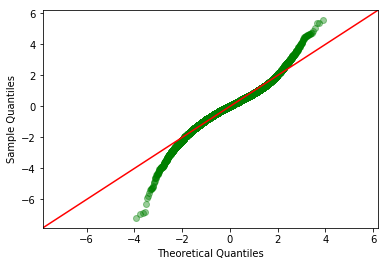

In [90]:
fig = sm.graphics.qqplot(ols_model_1.resid, dist=stats.norm, line=('45'), fit=True,color='green',alpha=.4)



> Variables behave linearly for about 2 standard deviations from the mean in each direction


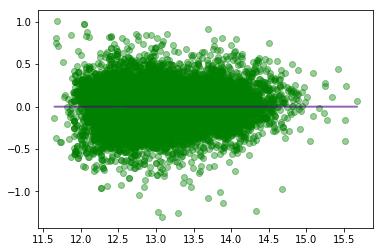

In [91]:
data_df1 = price_df.join(features_df,how='left')
plt.scatter(ols_model_1.predict(data_df1), ols_model_1.resid,color='green',alpha=.4)
plt.plot(ols_model_1.predict(data_df1), [0 for i in range(len(data_df1))],color='indigo',alpha=.6)
                                                      
                                                      

> Overall this is a good result.

## ITERATION 2

### Explore Variable Relationships

#### Bedrooms vs. Living Area

Text(0, 0.5, 'Living Area (sqft)')

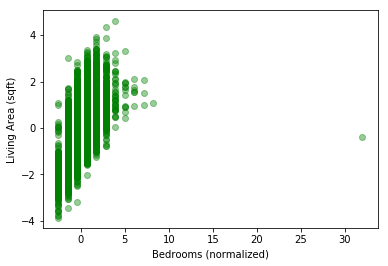

In [92]:
plt.scatter(features_df.bedrooms,features_df.sqft_living,color='green',alpha=0.4)
plt.xlabel('Bedrooms (normalized)')
plt.ylabel('Living Area (sqft)')

This datapoint (33 bedrooms) looks like a typing error. Maybe they meant 3 bedrooms

In [93]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [94]:
# let's find out this datapoint in the dataframe
features_df.loc[df['bedrooms'] == 33]

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_living15,sqft_lot15,approx_dist,flo_1,flo_2plus,...,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,base_0,base_1
id,,,,,,,,,,,,,,,,,,,,,
2402100895,31.984061,-0.475727,-0.378459,-0.321801,-0.560787,-1.058303,-0.295452,-0.774277,1,0,...,0,0,0,0,0,0,0,0,0,1


In [95]:
df.loc[df['bedrooms'] == 11]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
1773100755,8/21/2014,520000.0,11,3.0,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.556,-122.363,1420,4960


In [96]:
df.loc[df['bedrooms'] == 10]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
5566100170,10/29/2014,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914
8812401450,12/29/2014,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745
627300145,8/14/2014,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400


It is clear this was a typo, a house with 1620 sqft cannot have 33 bedrooms

In [97]:
# Let's replace this value with the log value for 3, which is the median
value = (3 - df.bedrooms.mean()) / df.bedrooms.std()
features_df.loc[2402100895,'bedrooms'] = value
features_df.loc[1773100755,'bedrooms'] = value
features_df.loc[5566100170,'bedrooms'] = value

Text(0, 0.5, 'Living Area (sqft)')

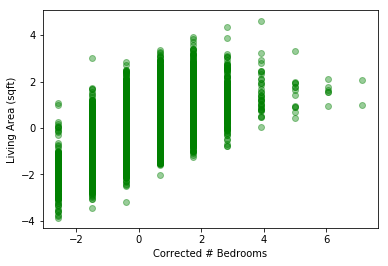

In [98]:
plt.scatter(features_df.bedrooms,features_df.sqft_living, color='green',alpha=0.4)
plt.xlabel('Corrected # Bedrooms')
plt.ylabel('Living Area (sqft)')

> Much better!

#### Remove Binary / Singular Categories

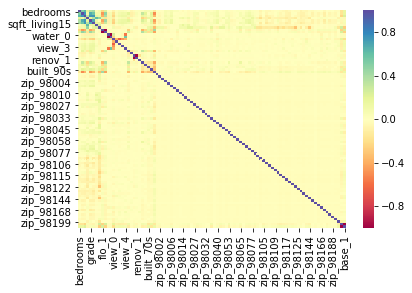

In [99]:
sns.heatmap(features_df.corr(), center=0, cmap='Spectral');

In [100]:
features_df.drop('water_0',axis=1,inplace=True)  # Remove no waterfront
features_df.drop('renov_0',axis=1,inplace=True) # Remove no renovations



In [101]:
features_df.drop('flo_1',axis=1,inplace=True)


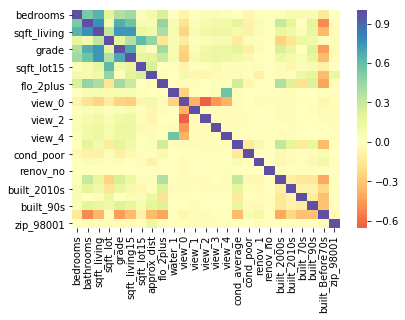

In [102]:
sns.heatmap(features_df.corr().iloc[0:25,0:25], center=0, cmap='Spectral');

In [103]:
# Find features correlated with sqft_living
features_df.corr().iloc[2,0:25]>.6

bedrooms            True
bathrooms           True
sqft_living         True
sqft_lot           False
grade               True
sqft_living15       True
sqft_lot15         False
approx_dist        False
flo_2plus          False
water_1            False
view_0             False
view_1             False
view_2             False
view_3             False
view_4             False
cond_average       False
cond_poor          False
renov_1            False
renov_no           False
built_2000s        False
built_2010s        False
built_70s          False
built_90s          False
built_Before70s    False
zip_98001          False
Name: sqft_living, dtype: bool

In [104]:
features_df.drop('bathrooms',axis=1,inplace=True)
features_df.drop('bedrooms',axis=1,inplace=True)

In [105]:
features_df.drop('sqft_living15',axis=1,inplace=True)
features_df.drop('grade',axis=1,inplace=True)

In [106]:
features_df.drop('base_0', axis=1,inplace=True)

In [107]:
features_df.drop('view_0', axis=1,inplace=True)

In [108]:
features_df.drop('sqft_lot15', axis=1,inplace=True)

In [109]:
features_df.drop('built_Before70s', axis=1,inplace=True)

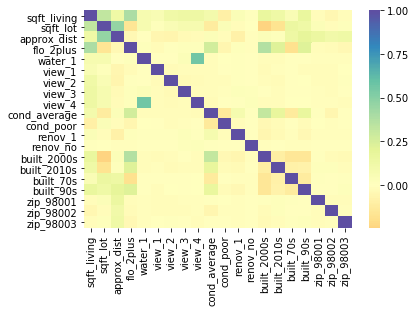

In [110]:
sns.heatmap(features_df.corr().iloc[0:20,0:20], center=0, cmap='Spectral');

### Run Second Iteration

In [111]:
linreg2 = run_single_linreg(features_df, price_df,0.05)
predictors2 = list(linreg2.index)
features_df = features_df[predictors2]
len(predictors2)

82

In [112]:
mult_linreg2 = run_mult_linreg(features_df, price_df, predictors2)

0.8062690535990711
0.8098265941725655
0.8125280743956385
0.8134073830404892
0.8172438827783822
0.8185587796587221
0.8190459031330456
0.8208298494218844
0.8219555816541697
0.8230799583159226
0.823930811448384
0.8247193531956993
0.8259403814887489
0.8262762146467244
0.8266965903870082
0.8272428904987832
0.8275182233099482
0.8276232700684603
0.8432149269516814
0.8437109722280363
0.8442947833504265
0.844528235424521
0.8449684828987133
0.8455001693871642
0.8464286773350063
0.8465146942168624
0.8568259138840836
0.8594213778894186
0.8609873282507451
0.8610000986683366
0.8629508075296762
0.8630649623778661
0.864502207484399
0.8646163500124437
0.8646821799984423
0.8646953767655435
0.8647153241966465
0.8647450263704234
0.8648220847149626
0.8648250141082674
0.864831193397525
r-squared: [0.864831193397525]
adj r-squared: [0.8643160013299689]


In [113]:
run_cross_validation(mult_linreg2,features_df,price_df,predictors2,10)

82 predictors used.
[-0.09425213 -0.03346233 -0.03101765 -0.03131385 -0.03209443 -0.03264554
 -0.03005204 -0.02998032 -0.03361674 -0.12923226]


In [114]:
ols_model_2 = run_ols_model(features_df,price_df,predictors2)
ols_model_2.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 83 columns):
price           21953 non-null float64
sqft_living     21953 non-null float64
sqft_lot        21953 non-null float64
approx_dist     21953 non-null float64
flo_2plus       21953 non-null uint8
water_1         21953 non-null uint8
view_1          21953 non-null uint8
view_2          21953 non-null uint8
view_3          21953 non-null uint8
view_4          21953 non-null uint8
cond_average    21953 non-null uint8
cond_poor       21953 non-null uint8
renov_1         21953 non-null uint8
renov_no        21953 non-null uint8
built_2000s     21953 non-null uint8
built_2010s     21953 non-null uint8
built_70s       21953 non-null uint8
built_90s       21953 non-null uint8
zip_98001       21953 non-null uint8
zip_98002       21953 non-null uint8
zip_98003       21953 non-null uint8
zip_98004       21953 non-null uint8
zip_98005       21953 non-null uint8
zip_98006       21953

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1675.
Date:                Tue, 25 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:12:23   Log-Likelihood:                 4614.3
No. Observations:               21953   AIC:                            -9063.
Df Residuals:                   21870   BIC:                            -8399.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0263      0.006   2107.138      0.000      13.014      13.038
sqft_living      0.2608      0.002    125.784      0.000       0.257       0.265
sqft_lot         0.0888      0.002     43.858      0.000       0.085       0.093
approx_dist     -0.1967      0.007    -29.887      0.000      -0.210      -0.184
flo_2plus        0.0062      0.004      1.630      0.103      -0.001       0.014
water_1          0.4133      0.020     20.714      0.000       0.374       0.452
view_1           0.1527      0.011     13.774      0.000       0.131       0.174
view_2           0.1550      0.007     23.048      0.000       0.142       0.168
view_3           0.2484      0.009     27.328      0.000       0.231       0.266
view_4           0.4160      0.014     30.395      0.000       0.389       0.443
cond_average    -0.0492      0.003    -15.097      0.000      -0.056      -0.043
cond_poor       -0.2242      0.014    -16.424      0.000      -0.251      -0.197
renov_1          0.1435      0.011     13.479      0.000       0.123       0.164
renov_no        -0.0540      0.053     -1.025      0.305      -0.157       0.049
built_2000s      0.1090      0.005     21.350      0.000       0.099       0.119
built_2010s      0.1865      0.007     26.896      0.000       0.173       0.200
built_70s       -0.0158      0.005     -3.342      0.001      -0.025      -0.007
built_90s        0.0729      0.005     13.784      0.000       0.063       0.083
zip_98001       -0.3046      0.013    -23.983      0.000      -0.330      -0.280
zip_98002       -0.3159      0.016    -19.821      0.000      -0.347      -0.285
zip_98003       -0.2452      0.014    -17.867      0.000      -0.272      -0.218
zip_98004        0.5986      0.014     44.121      0.000       0.572       0.625
zip_98005        0.2765      0.016     16.844      0.000       0.244       0.309
zip_98006        0.2446      0.010     23.868      0.000       0.224       0.265
zip_98007        0.2014      0.017     11.685      0.000       0.168       0.235
zip_98008        0.2148      0.013     16.825      0.000       0.190       0.240
zip_98010       -0.0371      0.021     -1.737      0.082      -0.079       0.005
zip_98014       -0.0166      0.019     -0.858      0.391      -0.054       0.021
zip_98019       -0.0167      0.016     -1.045      0.296      -0.048       0.015
zip_98022       -0.1585      0.017     -9.330      0.000      -0.192      -0.125
zip_98023       -0.2655      0.012    -23.025      0.000      -0.288      -0.243
zip_98027        0.1815      0.011     16.401      0.000       0.160       0.203
zip_98029        0.3236      0.013     25.859      0.000       0.299       0.348
zip_98030       -0.2865      0.014    -20.834      0.000      -0.313      -0.260
zip_98031       -0.2812      0.013    -21.437      0.000      -0.307      -0.255
zip_9

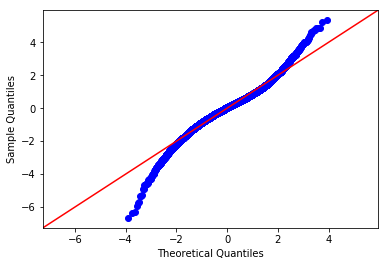

In [115]:
fig = sm.graphics.qqplot(ols_model_2.resid, dist=stats.norm, line='45', fit=True)

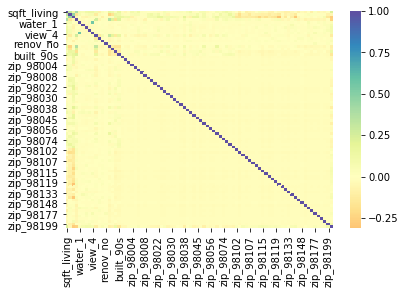

In [116]:
sns.heatmap(features_df.corr(), center=0, cmap='Spectral');

### Run 3rd Iteration

In [117]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [118]:
predictors3 = stepwise_selection(features_df, price_df)

Add  sqft_living                    with p-value 0.0
Add  approx_dist                    with p-value 0.0
Add  zip_98004                      with p-value 1.19255e-193
Add  view_4                         with p-value 1.66199e-185
Add  sqft_lot                       with p-value 1.5556e-150
Add  zip_98168                      with p-value 3.23221e-166
Add  zip_98106                      with p-value 2.48262e-117
Add  zip_98178                      with p-value 1.60915e-116
Add  zip_98144                      with p-value 7.88845e-115
Add  zip_98108                      with p-value 7.67292e-129
Add  zip_98118                      with p-value 3.3672e-133
Add  zip_98122                      with p-value 3.602e-135
Add  zip_98146                      with p-value 1.3205e-132
Add  base_1                         with p-value 1.01434e-137
Add  zip_98029                      with p-value 2.14283e-126
Add  zip_98126                      with p-value 2.30493e-89
Add  zip_98053                  

In [119]:
len(predictors3)

75

In [120]:
### Run 3rd Iteration

In [121]:
features_df = features_df[predictors3]
#Run the third linear regression and print r-squared values
mult_linreg3 = run_mult_linreg(features_df,price_df,predictors3)

0.7950041727944057
0.7998086615964826
0.8018483551501866
0.8046409459456851
0.8062690535990711
0.8098265941725655
0.8125280743956385
0.8134073830404892
0.8172438827783822
0.8185587796587221
0.8190459031330456
0.8208298494218844
0.8219555816541697
0.8230799583159226
0.823930811448384
0.8247193531956992
0.8259403814887489
0.8262762146467244
0.8266965903870082
0.8272428904987832
0.8275182233099482
0.8276232700684603
0.8432149269516815
0.8437109722280363
0.8442947833504264
0.844528235424521
0.8449684828987133
0.8455001693871642
0.8464286773350063
0.8465146942168624
0.8568259138840836
0.8594213778894186
0.8609873282507451
0.8629367852070151
0.8630508836921544
0.8644950528688605
0.8646093882172236
0.8646751872004821
r-squared: [0.8646751872004821]
adj r-squared: [0.8642035845351801]


In [122]:
run_cross_validation(mult_linreg3,features_df,price_df,predictors3,10)

75 predictors used.
[-0.09412539 -0.03351037 -0.03094663 -0.03134622 -0.03194108 -0.03263883
 -0.02999218 -0.02990553 -0.03353644 -0.12844688]


In [123]:
ols_model_2 = run_ols_model(features_df,price_df,predictors3)
ols_model_2.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 76 columns):
price           21953 non-null float64
sqft_living     21953 non-null float64
approx_dist     21953 non-null float64
zip_98004       21953 non-null uint8
view_4          21953 non-null uint8
sqft_lot        21953 non-null float64
zip_98168       21953 non-null uint8
zip_98106       21953 non-null uint8
zip_98178       21953 non-null uint8
zip_98144       21953 non-null uint8
zip_98108       21953 non-null uint8
zip_98118       21953 non-null uint8
zip_98122       21953 non-null uint8
zip_98146       21953 non-null uint8
base_1          21953 non-null uint8
zip_98029       21953 non-null uint8
zip_98126       21953 non-null uint8
zip_98053       21953 non-null uint8
zip_98075       21953 non-null uint8
zip_98065       21953 non-null uint8
zip_98052       21953 non-null uint8
zip_98074       21953 non-null uint8
zip_98033       21953 non-null uint8
zip_98045       21953

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1830.
Date:                Tue, 25 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:14:25   Log-Likelihood:                 4605.3
No. Observations:               21953   AIC:                            -9059.
Df Residuals:                   21877   BIC:                            -8451.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0175      0.005   2699.758      0.000      13.008      13.027
sqft_living      0.2627      0.002    141.417      0.000       0.259       0.266
approx_dist     -0.1972      0.006    -35.780      0.000      -0.208      -0.186
zip_98004        0.6089      0.013     47.503      0.000       0.584       0.634
view_4           0.4150      0.014     30.329      0.000       0.388       0.442
sqft_lot         0.0885      0.002     44.479      0.000       0.085       0.092
zip_98168       -0.4936      0.013    -38.709      0.000      -0.519      -0.469
zip_98106       -0.3194      0.013    -23.893      0.000      -0.346      -0.293
zip_98178       -0.3901      0.013    -30.341      0.000      -0.415      -0.365
zip_98144       -0.1821      0.018    -10.236      0.000      -0.217      -0.147
zip_98108       -0.3590      0.017    -20.874      0.000      -0.393      -0.325
zip_98118       -0.1787      0.012    -15.317      0.000      -0.202      -0.156
zip_98122       -0.0784      0.020     -3.908      0.000      -0.118      -0.039
zip_98146       -0.3086      0.013    -24.569      0.000      -0.333      -0.284
base_1          -0.0555      0.003    -17.322      0.000      -0.062      -0.049
zip_98029        0.3363      0.012     28.228      0.000       0.313       0.360
zip_98126       -0.1112      0.014     -8.222      0.000      -0.138      -0.085
zip_98053        0.2393      0.011     22.382      0.000       0.218       0.260
zip_98075        0.2776      0.011     24.805      0.000       0.256       0.299
zip_98065        0.1546      0.013     11.902      0.000       0.129       0.180
zip_98052        0.2644      0.009     29.506      0.000       0.247       0.282
zip_98074        0.2550      0.010     25.392      0.000       0.235       0.275
zip_98033        0.3223      0.010     30.875      0.000       0.302       0.343
zip_98045        0.1184      0.015      7.731      0.000       0.088       0.148
zip_98027        0.1937      0.010     18.495      0.000       0.173       0.214
view_3           0.2483      0.009     27.316      0.000       0.230       0.266
zip_98006        0.2551      0.010     26.227      0.000       0.236       0.274
water_1          0.4161      0.020     20.874      0.000       0.377       0.455
zip_98188       -0.3619      0.017    -21.119      0.000      -0.396      -0.328
zip_98055       -0.2811      0.012    -22.997      0.000      -0.305      -0.257
zip_98039        0.7695      0.029     26.926      0.000       0.713       0.825
view_2           0.1550      0.007     23.037      0.000       0.142       0.168
zip_98040        0.3780      0.014     27.680      0.000       0.351       0.405
zip_98198       -0.2999      0.012    -24.347      0.000      -0.324      -0.276
zip_98056       -0.1673      0.011    -15.929      0.000      -0.188      -0.147
built

In [124]:
# Final check on correlated variables
find_corr_vars(features_df,0.7)

Numbers of variables tested
75
Correlations tested:
5625
Correlations meeting threshhold:
0

Correlated Variables over threshhold 0.7


,col1,col2


### QC: Train/Test MSE

In [125]:
from sklearn.model_selection import train_test_split
X = features_df[predictors3]
y = price_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3)

linreg = LinearRegression()
MSE_test = []
MSE_train = []
list_n = list(range(6,86,10))
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(X_train, np.ravel(y_train))
    selected_columns = X.columns[select_n.support_ ]
    linreg.fit(X_train[selected_columns],y_train)
    yhat_train = linreg.predict(X_train[selected_columns])
    yhat_test = linreg.predict(X_test[selected_columns])
    mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
    mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
    print(mse_train)
    print(mse_test)
MSE_test.append(mse_test)
MSE_train.append(mse_train)
print(n)


price    0.225486
dtype: float64
price    0.212157
dtype: float64
price    0.191432
dtype: float64
price    0.178607
dtype: float64
price    0.163301
dtype: float64
price    0.152796
dtype: float64
price    0.057716
dtype: float64
price    0.05616
dtype: float64
price    0.050552
dtype: float64
price    0.04946
dtype: float64
price    0.048088
dtype: float64
price    0.046275
dtype: float64
price    0.04299
dtype: float64
price    0.040992
dtype: float64
price    0.037806
dtype: float64
price    0.036482
dtype: float64
76


MSE between train set and test set is almost identical and fairly close to zero (0.037). This is a good result and shows the model is robust.

### Conclusions / Interpretation

R-Squared result: 86.5% of the variations in price are explained by the following variables:

In [127]:
print(predictors3)

['sqft_living', 'approx_dist', 'zip_98004', 'view_4', 'sqft_lot', 'zip_98168', 'zip_98106', 'zip_98178', 'zip_98144', 'zip_98108', 'zip_98118', 'zip_98122', 'zip_98146', 'base_1', 'zip_98029', 'zip_98126', 'zip_98053', 'zip_98075', 'zip_98065', 'zip_98052', 'zip_98074', 'zip_98033', 'zip_98045', 'zip_98027', 'view_3', 'zip_98006', 'water_1', 'zip_98188', 'zip_98055', 'zip_98039', 'view_2', 'zip_98040', 'zip_98198', 'zip_98056', 'built_2010s', 'built_2000s', 'zip_98008', 'zip_98077', 'zip_98117', 'zip_98072', 'cond_poor', 'zip_98115', 'zip_98105', 'zip_98005', 'view_1', 'built_90s', 'zip_98177', 'zip_98007', 'zip_98031', 'cond_average', 'renov_1', 'zip_98032', 'zip_98001', 'zip_98058', 'zip_98030', 'zip_98166', 'zip_98023', 'zip_98042', 'zip_98002', 'zip_98003', 'zip_98092', 'zip_98148', 'zip_98103', 'zip_98107', 'zip_98199', 'zip_98112', 'zip_98119', 'zip_98038', 'zip_98022', 'zip_98109', 'zip_98102', 'zip_98136', 'zip_98125', 'built_70s', 'zip_98116']


### Interpretation

#### Top contributors to value
> Location in premium zipcodes: Medina, Bellevue, etc. drive price up. Location in negative zipcodes drive price down.

> Waterfront view from home.

> Square footage of living space.

> Distance to Seattle

> Built Recently, Renovated Recently

### Recommendations

In conclusion, my three main recommendation for you if you are selling. First, enter the market around late February so that you take advantage of the increased interest in touring properties. Second, if you have the budget to do so, renovate older homes and add extra square footage prior to going to market. Third, if you are selling a waterfront property, make sure to list this fact on any listing (and take professional pictures!)

### Future Work

There are a few ideas for future work including exploring the relationship between views and price more deeply. In addition, since the dataset was limited to the years 2014 and 2015, it would be beneficial to include additional years and analyze any potential changes to the mean prices. If I had all the time in the world, I would make more maps because 1) I love maps and 2) we could visualize the geographical distributions and make geographic inferences more easily! Understanding what makes a zipcode a 'premium' or 'negative' location would be valuable as well. As a geoscientist by background, I would be interested to plot the volcanic eruption/lahar risk maps for Mt. Rainier and whether there is an overlap with lower property values.

<img src="house_banner.png"/>

Completed by Valentina C. Fontiveros on Jun 9, 2019